<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/pyro_count_regression_student_awards_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://www.kaggle.com/gauravduttakiit/explore-the-poisson-regression/notebook

In [1]:
pip install pyro-ppl=='1.8.0'

     |████████████████████████████████| 713 kB 9.3 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 6]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/seanreed1111/datasets/master/count-regression-datasets/competition_awards_data.csv")
df.columns = ['award_count', 'math_score']
df.head()

,award_count,math_score
0,0,43
1,0,38
2,0,41
3,0,33
4,0,39


In [4]:
df.describe()

,award_count,math_score
count,200.000000,200.000000
mean,0.630000,50.715000
std,1.052921,19.148029
min,0.000000,30.000000
25%,0.000000,35.000000
50%,0.000000,42.000000
75%,1.000000,66.000000
max,6.000000,91.000000


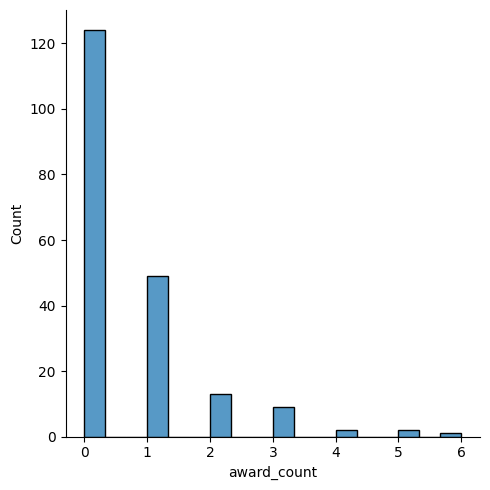

In [5]:
X = df.copy()
sns.displot(data=X, x='award_count', palette='colorblind');

Poisson Distribution should have equal mean and variance. Let's check:

In [6]:
X['award_count'].mean(), X['award_count'].var() # Variance larger than the mean. Overdispersed.

(0.63, 1.108643216080402)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


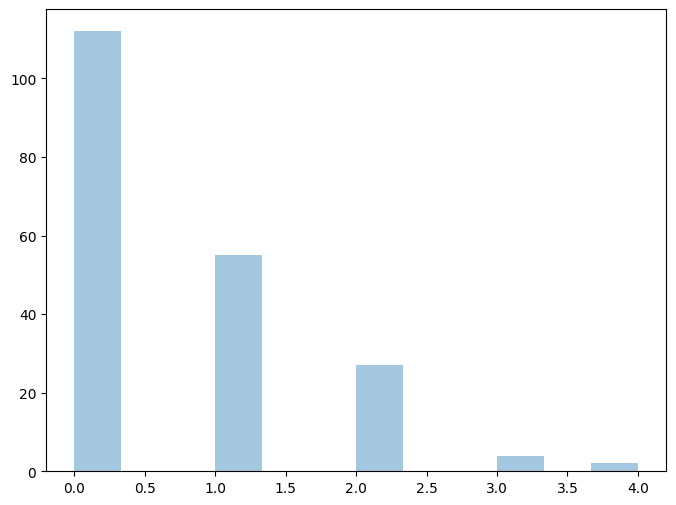

In [7]:
samples_1 = dist.Poisson(X['award_count'].mean()).sample(tensor([200])) # create sample distribution where Poisson mean = data mean
sns.distplot(samples_1.numpy(), kde=False);

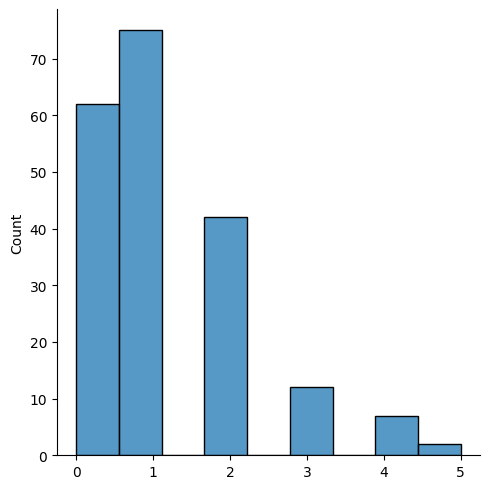

In [8]:
samples_2 = dist.Poisson(X['award_count'].var()).sample(tensor([200])) # create sample distribution where Poisson mean = data variance
sns.displot(samples_2.numpy());

### So, comparing the actual data with the above two poisson sampling distributions above, it appears our data is both zero inflated AND overdispersed!

let's make a Poisson model with 'award_count ~ math_score' 

In [9]:
data = X[['math_score']]
target = X['award_count']

## Using sklearn

In [10]:
data.shape, target.shape

((200, 1), (200,))

In [29]:
from sklearn.linear_model import PoissonRegressor #Generalized Linear Model with a Poisson distribution and log link.
from sklearn.metrics import mean_poisson_deviance, mean_absolute_percentage_error, mean_squared_error
reg = PoissonRegressor(alpha=0).fit(data.values, target.values) #alpha = 0 is unpenalized poisson regression
# these are MLE estimates of parameters we expect to recover
print(f'ln(award_count)] = {reg.intercept_:.2f} + {reg.coef_[0]:.2f}* (math_score)')

# score : D^2, the percentage of deviance explained.
# see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor.score

print(f'percentage of deviance explained = {reg.score(data.values.reshape(-1,1), target):.2f}') 

ln(award_count)] = -5.51 + 0.08* (math_score)
Accuracy = 0.86


In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, X, y_true):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(X)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            y_true, y_pred
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            y_true, y_pred
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            y_true[mask],
            y_pred[mask]
        )
    )


print("Metric evaluation:")
score_estimator(reg, data, target)

Metric evaluation:
MSE: 0.147
MAE: 0.239
mean Poisson deviance: 0.199


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## Using statsmodels

In [36]:
import statsmodels.formula.api as smf
statsmod = smf.poisson(formula='award_count ~ math_score', data=X)
result = statsmod.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.539676
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:            award_count   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                  0.5345
Time:                        16:53:01   Log-Likelihood:                -107.94
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 7.616e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5094      0.487    -11.319      0.000      -6.463      -4.555
math_score     0.0765      0.

## Using Bayesian Regression with SVI

In [37]:
# convert data and target to torch tensors
data = tensor(data.values, dtype=torch.float)
target = tensor(target.values, dtype=torch.float)
data.size(), target.size()

(torch.Size([200, 1]), torch.Size([200]))

In [38]:
from torch import nn
from pyro.nn import PyroSample, PyroModule

# need to pass the priors for all models as parameters to the object.
class BayesianPoissonRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        if bias:
          self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))
        self.linear.weight = PyroSample(dist.Normal(0., 0.05).expand([out_features, in_features]).to_event(2))

        
    def forward(self, x, y=None):
        rate = self.linear(x).squeeze(-1).exp() #we are using log link, so apply inverse of log to the matrix multiplication, i.e. exp
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Poisson(rate), obs=y)
        return rate

In [39]:
model = BayesianPoissonRegression(data.size(1)) 

In [40]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [65]:
def train(model, guide, lr=0.01, n_steps=3000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target)
        if i % 250 == 0:
          print(f"Elbo loss: {elbo}")
    print(f"Final Elbo loss: {elbo}")

In [66]:
train(model, guide)

Elbo loss: 131.2149614095688
Elbo loss: 127.87513411045074
Elbo loss: 124.92014729976654
Elbo loss: 122.81878364086151
Elbo loss: 123.73111546039581
Elbo loss: 121.2422901391983
Elbo loss: 116.12664115428925
Elbo loss: 118.98910415172577
Elbo loss: 113.77371168136597
Elbo loss: 118.92469203472137
Elbo loss: 117.45555627346039
Elbo loss: 120.97884666919708
Final Elbo loss: 120.45192492008209


In [71]:
from pyro.infer import Predictive

num_samples = 3000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data, target).items()
               if k != "obs"}

In [46]:
svi_samples.keys()

dict_keys(['linear.weight', 'linear.bias'])

In [47]:
svi_samples['linear.bias'].mean()

-2.8094525

In [72]:
svi_samples['linear.weight'].mean(axis=0)

array([0.06314264], dtype=float32)

In [50]:
print(reg.intercept_)
print(reg.coef_)

-5.509361449652388
[0.07648628]


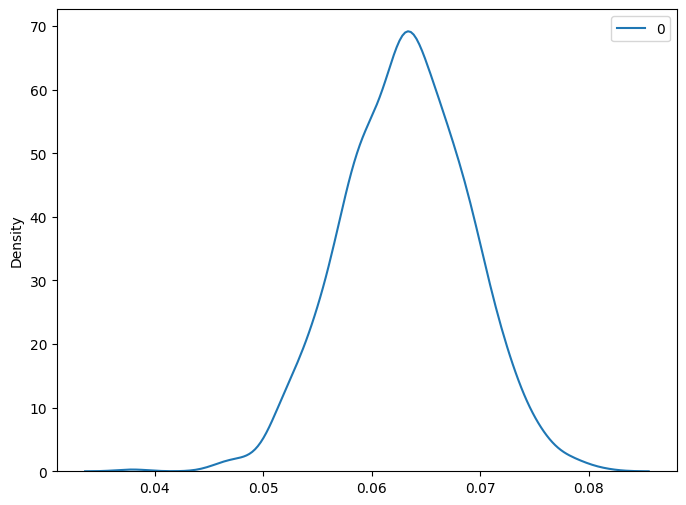

In [70]:
sns.kdeplot(data = svi_samples['linear.weight']);

In [ ]:
# So SVI seem to be off about the central tendencies of the slope coefficients.
# Will MCMC perform better??

# What about MCMC?

In [51]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=800, warmup_steps=200)

In [52]:
%%time
mcmc.run(data, target)

Sample: 100%|██████████| 1000/1000 [00:31, 32.17it/s, step size=1.00e-01, acc. prob=0.933]

CPU times: user 30.8 s, sys: 144 ms, total: 31 s
Wall time: 31.1 s


In [53]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

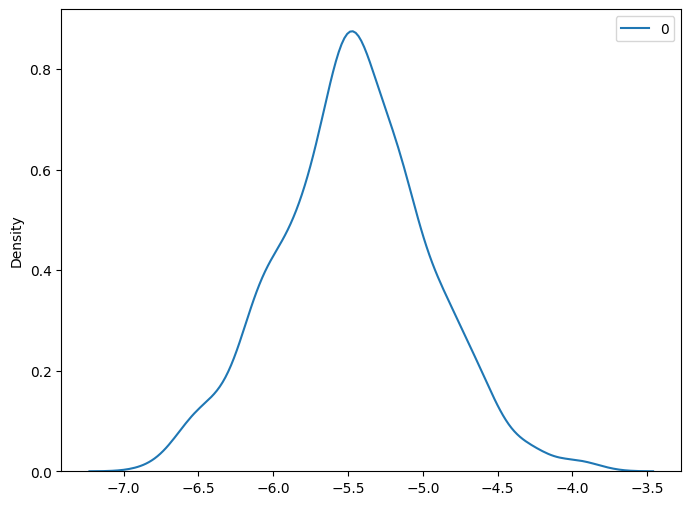

In [56]:
sns.kdeplot(data=hmc_samples['linear.bias']);

In [ ]:
hmc_samples['linear.weight'].shape

(800, 1, 1)

Median = 0.07588279247283936, Mean = 0.07574550807476044


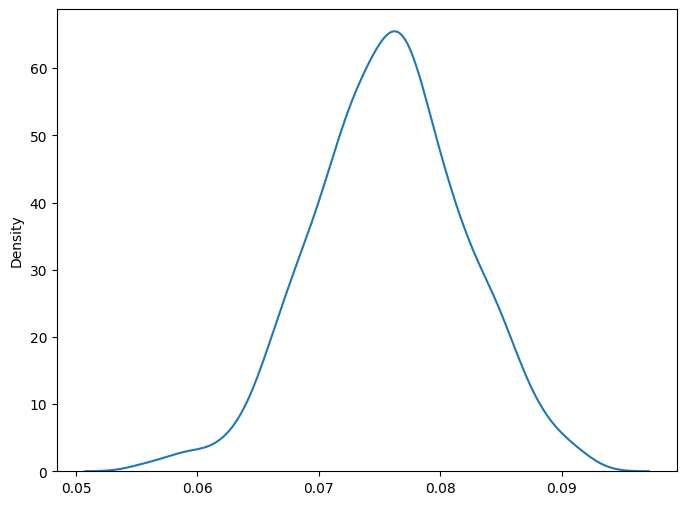

In [63]:
print(f'Median = {np.median(hmc_samples["linear.weight"][:,0,0])}, Mean = {np.mean(hmc_samples["linear.weight"][:,0,0])}')

sns.kdeplot(data=hmc_samples['linear.weight'][:,0,0]);

In [ ]:
# sklearn estimate
print(reg.intercept_)
print(reg.coef_)


-5.465562509571889
[0.0759304]


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  "Could not get vectorized trace, log_likelihood group will be omitted. "


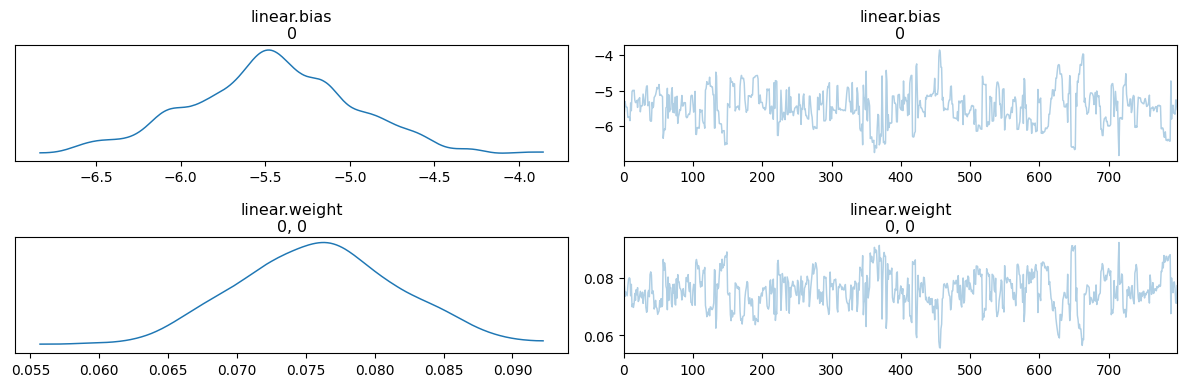

In [58]:
import arviz as az

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data, compact=False)
plt.tight_layout()

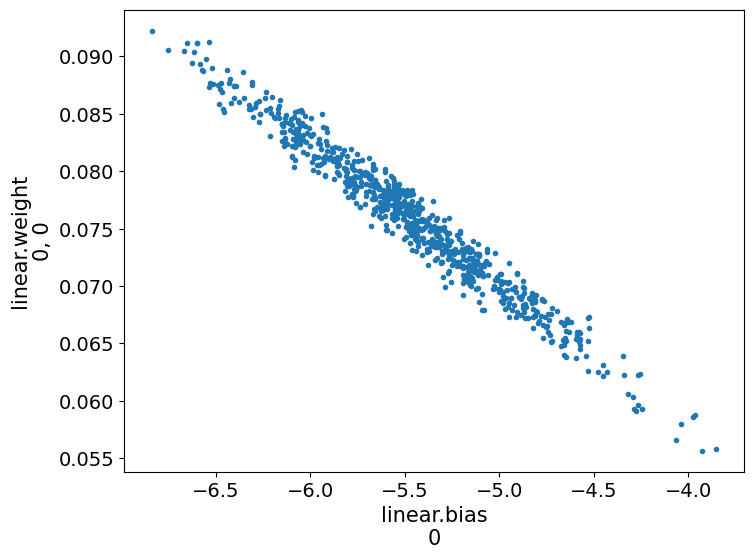

In [64]:
az.plot_pair(az_data);